In [22]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# 丢弃离群点
def drop_outlier(array, count, bins):
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma * 2, mean - sigma * 2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

# 从xlsx文件中提取当电池信息
battery_names = ["CS2_35", "CS2_36", "CS2_37", "CS2_38"]
data_path = "../../data/raw_data/calce/"
calce_data = {}
for name in battery_names:
    print("Load Dataset " + name + " ...")
    path = glob.glob(data_path + name + "/*.xlsx")
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print("Load " + str(p) + " ...")
        dates.append(df["Date_Time"][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print("Load " + str(p) + " ...")
        cycles = list(set(df["Cycle_Index"]))
        for c in cycles:
            df_lim = df[df["Cycle_Index"] == c]
            # Charging
            df_c = df_lim[(df_lim["Step_Index"] == 2) | (df_lim["Step_Index"] == 4)]
            c_v = df_c["Voltage(V)"]
            c_c = df_c["Current(A)"]
            c_t = df_c["Test_Time(s)"]
            # CC or CV
            df_cc = df_lim[df_lim["Step_Index"] == 2]
            df_cv = df_lim[df_lim["Step_Index"] == 4]
            CCCT.append(np.max(df_cc["Test_Time(s)"]) - np.min(df_cc["Test_Time(s)"]))
            CVCT.append(np.max(df_cv["Test_Time(s)"]) - np.min(df_cv["Test_Time(s)"]))

            # Discharging
            df_d = df_lim[df_lim["Step_Index"] == 7]
            d_v = df_d["Voltage(V)"]
            d_c = df_d["Current(A)"]
            d_t = df_d["Test_Time(s)"]
            d_im = df_d["Internal_Resistance(Ohm)"]

            if len(list(d_c)) != 0:
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff * d_c / 3600  # Q = A*h
                discharge_capacity = [
                    np.sum(discharge_capacity[:n])
                    for n in range(discharge_capacity.shape[0])
                ]
                discharge_capacities.append(-1 * discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame(
        {
            "cycle": np.linspace(1, idx.shape[0], idx.shape[0]),
            "capacity": discharge_capacities[idx],
            "SoH": health_indicator[idx],
            "resistance": internal_resistance[idx],
            "CCCT": CCCT[idx],
            "CVCT": CVCT[idx],
        }
    )
    calce_data[name] = df_result

Load Dataset CS2_35 ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_12_13_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_11_08_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_10_22_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_11_24_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_8_17_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_9_30_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_12_20_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_1_10_11.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_9_8_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_11_01_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_8_18_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_2_10_11.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_11_23_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_12_06_10.xlsx ...
Load ../../data/raw_data/calce/CS2_35/CS2_35_1_24_11.xlsx ...
Load ../../data/raw_data/calce/CS2_35/C

In [24]:
# 将容量信息保存到 npy 文件中
keys = list(calce_data.keys())
save_root_path = "../../data/processed_data/calce/"
save_name = "calce_capacity.npy"
save_path = os.path.join(save_root_path, save_name)
calce_capacity = np.array([calce_data[key]["capacity"].values for key in keys], dtype=object)
np.save(save_path, calce_capacity)
print(f"CALCE capacity data saved to path: {save_path}")

# 读取容量数据
load_capacity = np.load(save_path, allow_pickle=True)

# 容量退化曲线可视化
for idx in range(len(calce_capacity)):
    plt.plot(calce_capacity[idx])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    plt.savefig(f"../../assets/thesis_figures/chapter_2/calce_{battery_names[idx]}_capacity.jpg", dpi=1000, bbox_inches="tight")
    plt.clf()

CALCE capacity data saved to path: ../../data/processed_data/calce/calce_capacity.npy


<Figure size 640x480 with 0 Axes>

### 放电容量和内阻变化

In [38]:
battery = calce_data[battery_names[0]] # CS2_35

# 放电容量和内阻变化
plt.figure(figsize=(9,6))
plt.scatter(battery["cycle"], battery["SoH"], c=battery["resistance"], s=5)
cbar = plt.colorbar()
cbar.set_label('内阻（Ohm）', rotation=-90, labelpad=20)
plt.xlabel("循环圈数")
plt.ylabel("健康状态")
plt.savefig(f"../../assets/thesis_figures/chapter_2/calce_{battery_names[0]}_capacity_and_resistance.jpg", dpi=1000, bbox_inches="tight")
plt.clf()

<Figure size 900x600 with 0 Axes>

### 各项指标 v.s. 充放电周期

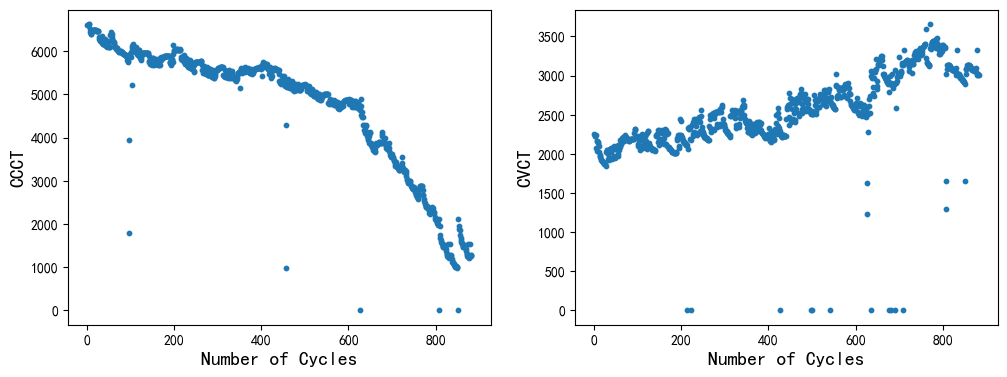

In [28]:
plt.figure(figsize=(12,9))
names = ['CCCT', 'CVCT']
for i in range(len(names)):
    plt.subplot(2, 2, i+1)
    plt.scatter(battery['cycle'], battery[names[i]], s=10)
    plt.xlabel('Number of Cycles', fontsize=14)
    plt.ylabel(names[i], fontsize=14)